### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'  
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt


import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from omegaconf import OmegaConf
import h5py

os.chdir('/home/x-mho1/git/ltu-cmass/matts_tests')


In [2]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

### Load training and test data

In [3]:
from cmass.bias.apply_hod import get_hod_params
def get_cosmo(source_path):
    cfg = OmegaConf.load(join(source_path, 'config.yaml'))
    return np.array(cfg.nbody.cosmo)

def get_halo_Pk(source_path):
    diag_file = join(source_path, 'diag', 'halos.h5')
    if not os.path.exists(diag_file):
        return None, None, None
    with h5py.File(diag_file, 'r') as f:
        a = list(f.keys())[-1]
        k = f[a]['Pk_k'][:]
        Pk = f[a]['Pk'][:]
    cosmo = get_cosmo(source_path)
    return k, Pk, cosmo

def get_lc_Pk(source_path, hod, aug):
    diag_file = join(source_path, 'diag', 'lightcone', f'hod{hod:05}_aug{aug:05}.h5')
    if not os.path.exists(diag_file):
        return None, None, None, None
    try:
        with h5py.File(diag_file, 'r') as f:
            k = f['Pk_k'][:]
            Pk = f['Pk'][:]
    except:
        return None, None, None, None

    cosmo = get_cosmo(source_path)
    hod = get_hod_params(hod)
    hod = [
        hod['logMmin'],
        hod['sigma_logM'],
        hod['logM0'],
        hod['logM1'],
        hod['alpha']
    ]
    return k, Pk, cosmo, hod
len(get_lc_Pk('/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/L3000-N384/3', 32, 0))

4

In [4]:
# Training suite
suite = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0, check=False)[:-2]


ktrain, Pktrain, cosmotrain, hodtrain = [], [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    lhid = int(lhid)
    for hod in range(10*lhid+1, 10*lhid+11):
        for aug in range(5):
            k, Pk, cosmo, hodi = get_lc_Pk(join(suite_path, str(lhid)), hod, aug)
            ktrain.append(k)
            Pktrain.append(Pk)
            cosmotrain.append(cosmo)
            hodtrain.append(hodi)

ktrain, Pktrain, cosmotrain, hodtrain = map(lambda x: [i for i in x if i is not None], [ktrain, Pktrain, cosmotrain, hodtrain])
ktrain, Pktrain, cosmotrain, hodtrain = map(np.stack, [ktrain, Pktrain, cosmotrain, hodtrain])
print(Pktrain.shape)

100%|██████████| 1941/1941 [12:55<00:00,  2.50it/s]


(65008, 332, 3)


In [5]:
cosmotrain

array([[0.2839 , 0.03261, 0.8777 , 0.9071 , 0.6379 ],
       [0.2839 , 0.03261, 0.8777 , 0.9071 , 0.6379 ],
       [0.2839 , 0.03261, 0.8777 , 0.9071 , 0.6379 ],
       ...,
       [0.2999 , 0.03999, 0.5089 , 1.1911 , 0.8979 ],
       [0.2999 , 0.03999, 0.5089 , 1.1911 , 0.8979 ],
       [0.2999 , 0.03999, 0.5089 , 1.1911 , 0.8979 ]])

In [36]:
ktest, Pktest, cosmotest, hodtest = ktrain[::37], Pktrain[::37], cosmotrain[::37], hodtrain[::37]

In [7]:
# # Test suite
# suite = 'mtng'
# sim = 'nbody'
# L, N = 3000, 384

# from cmass.utils import get_source_path

# suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


# ktest, Pktest, cosmotest = [], [], []
# for lhid in tqdm(os.listdir(suite_path)):
#     k, Pk, cosmo = get_halo_Pk(join(suite_path, '0'))
#     ktest.append(k)
#     Pktest.append(Pk)
#     cosmotest.append(cosmo)

# ktest, Pktest, cosmotest = map(lambda x: [i for i in x if i is not None], [ktest, Pktest, cosmotest])
# # ktest, Pktest, cosmotest = map(np.stack, [ktest, Pktest, cosmotest])

In [8]:
# Test suite
suite = 'cmass_ngc'
sim = 'cmass'
L, N = 0, 0

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktest, Pktest, cosmotest, hodtest = [], [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    lhid = int(lhid)
    hod=0
    aug=0
    k, Pk, cosmo, hodi = get_lc_Pk(join(suite_path, str(lhid)), hod, aug)
    k, Pk = map(np.array, (k,Pk))
    ktest.append(k)
    Pktest.append(Pk)
    cosmotest.append(cosmo)
    hodtest.append(hodi)

ktest, Pktest, cosmotest, hodtest = map(lambda x: [i for i in x if i is not None], [ktest, Pktest, cosmotest, hodtest])
# ktest, Pktest, cosmotest, hodtest = map(np.stack, [ktest, Pktest, cosmotest, hodtest])

100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


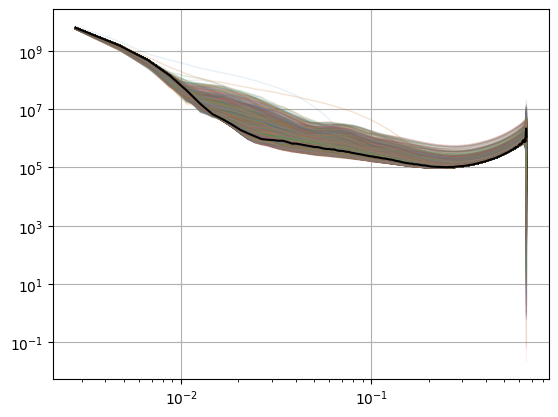

In [8]:
f, ax = plt.subplots()
ax.grid()
for k, Pk in zip(ktrain[::7], Pktrain[::7,...,0]):
    ax.loglog(k, Pk, lw=1, alpha=0.1)
# ax.loglog(ktest[0], Pktest[0,...,0], 'k')
ax.loglog(ktest[0], Pktest[0][...,0], 'k')

In [17]:
cosmotest.shape

(100, 5)

### Train

In [9]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.embedding import FCN
device='cpu'

def run_inference(x, theta):
    loader = NumpyLoader(x=x, theta=theta)

    # define a prior
    prior = ili.utils.Uniform(
        low=theta.min(axis=0),
        high=theta.max(axis=0),
        device=device)
    
    embedding_network = FCN([64, 64, 32, 16])

    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_lampe(model='nsf', hidden_features=50, num_transforms=5),
        # ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
    ]

    # define training arguments
    train_args = {
        'training_batch_size': 64,
        'learning_rate': 1e-4
    }

    # initialize the trainer
    runner = InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args
    )

    # train the model
    posterior_ensemble, summaries = runner(loader=loader)

    return posterior_ensemble, summaries

/anvil/projects/x-phy240043/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# train at different resolutions
kmaxs = [0.25] # [0.1, 0.2, 0.4]

# impute with mean
def impute(arr):
    # Compute the mean of each column, ignoring nan values
    col_mean = np.nanmean(arr, axis=0)
    
    # Find the indices where values are nan
    inds = np.where(np.isnan(arr))
    
    # Replace nan values with the mean of the respective column
    arr[inds] = np.take(col_mean, inds[1])
    return arr

In [12]:
posteriors, summaries = {}, {}
for kmax in kmaxs:
    print(f'Training for kmax={kmax}')

    # focus on the monopole
    x = Pktrain[:, :, 0]

    # cut on k
    mask = ktrain[0] < kmax
    x = x[:, mask]
    theta = np.concatenate([cosmotrain, hodtrain], axis=-1)

    # log
    x = np.log10(x)

    # impute
    x = impute(x)

    # train
    _p, _s = run_inference(x[::11], theta[::11])
    posteriors[kmax] = _p
    summaries[kmax] = _s


Training for kmax=0.25


[10:11:42-INFO] MODEL INFERENCE CLASS: NPE
[10:11:42-INFO] Training model 1 / 1.
247 epochs [12:05,  2.94s/ epochs, loss=-12.5, loss_val=-11.7]
[10:23:58-INFO] It took 736.4842031002045 seconds to train models.


In [38]:
# kmax = 0.25
_p = posteriors[kmax]
xobs = Pktest[:, :, 0]
mask = ktest[0] < kmax
xobs = xobs[:, mask]
xobs = np.log10(xobs)
# xobs = impute(xobs)
# i = 10
# xobs[i], cosmotest[i]
paramstest = np.concatenate([cosmotest, hodtest], axis=-1)

100%|██████████| 1757/1757 [19:22<00:00,  1.51it/s]  
[11:28:38-INFO] Mean logprob: 1.0225e+01Median logprob: 1.0511e+01
100%|██████████| 100/100 [00:13<00:00,  7.38it/s]
[11:28:53-INFO] Substituting symbol E from STIXNonUnicode


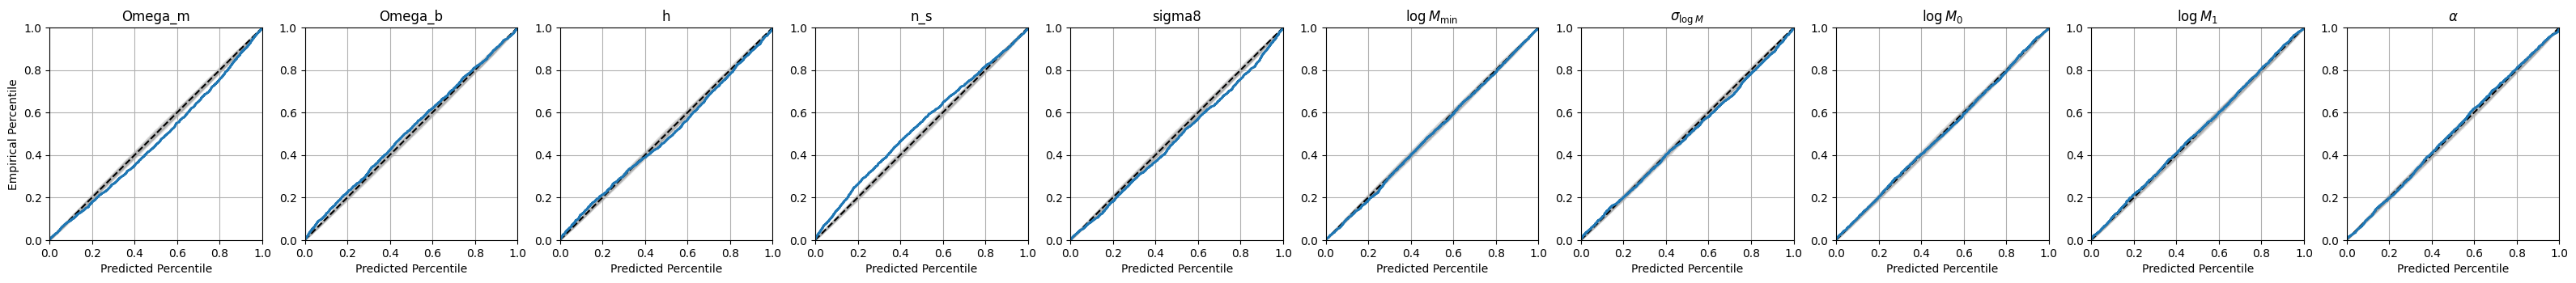

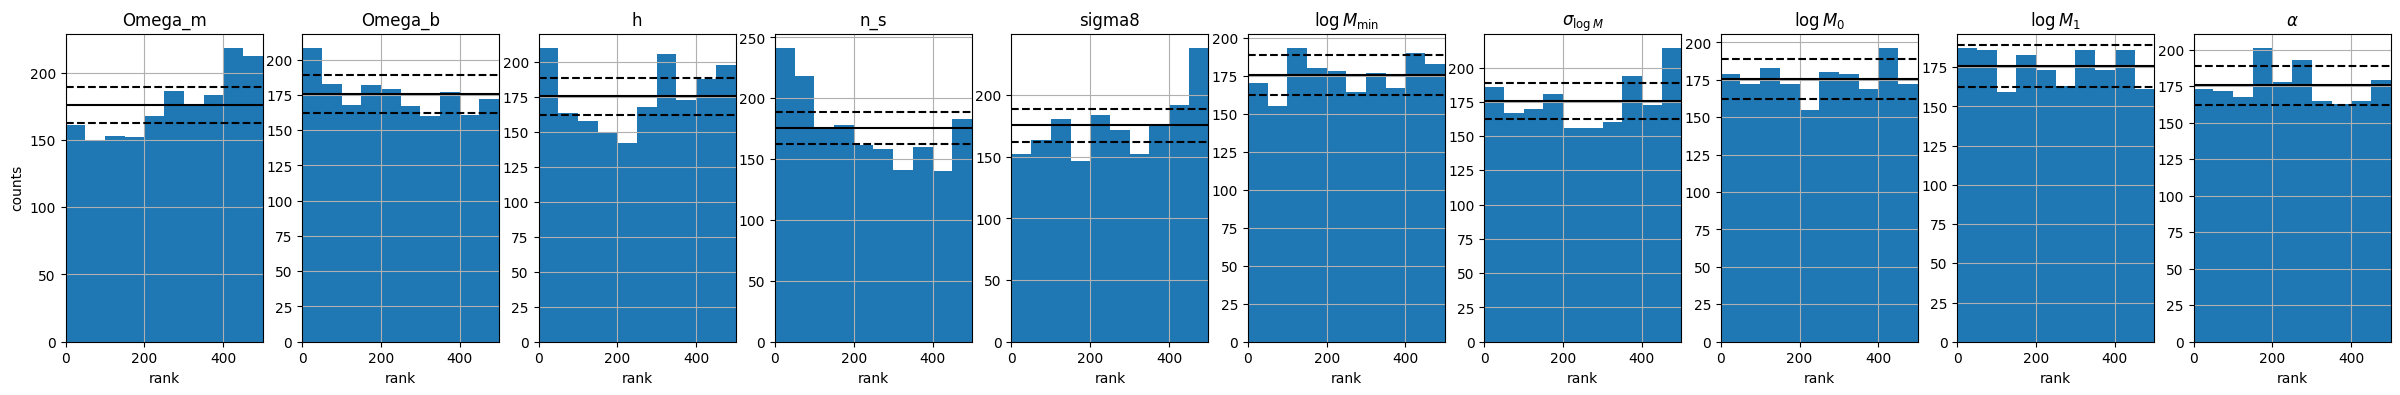

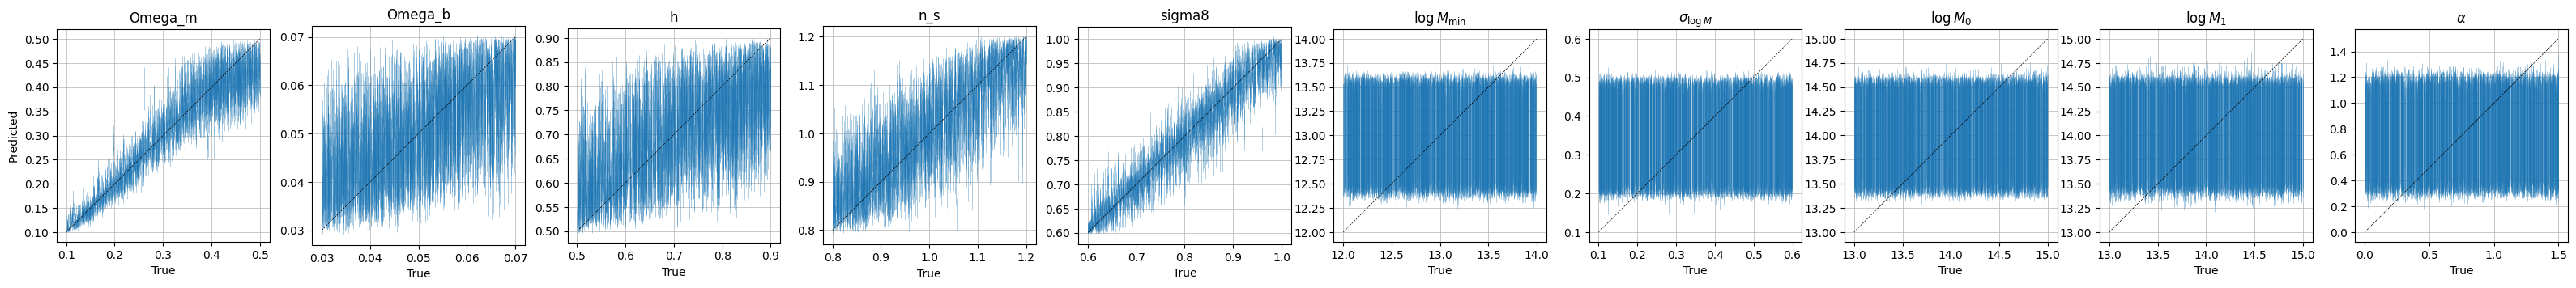

[11:28:55-INFO] Substituting symbol E from STIXNonUnicode


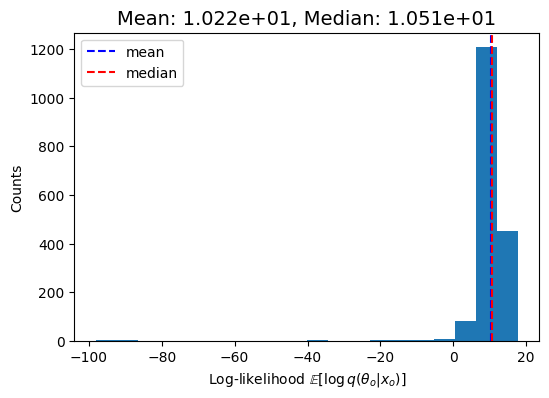

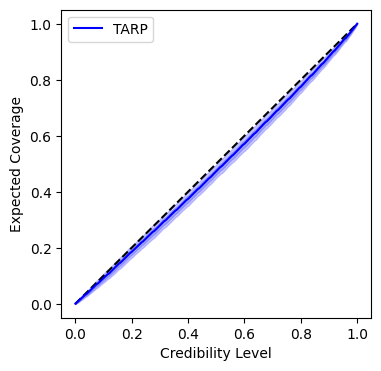

In [40]:
metric = PosteriorCoverage(
    num_samples=500, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'] + \
           [r'$\log M_{\rm min}$', r'$\sigma_{\log M}$', r'$\log M_0$', r'$\log M_1$',r'$\alpha$'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)
metric(posterior=_p, x=xobs, theta=paramstest);

In [28]:
paramstest.shape

(100, 10)

### Plot

In [13]:
xobs = np.array(Pktest)[..., 0]
mask = ktest[0] < kmax
xobs = xobs[:,mask]
xobs = np.log10(xobs)
# xobs = impute(xobs)
xobs = x[0]
# thetaobs = np.concatenate([cosmotest, hodtest], axis=-1)

In [48]:
out = posteriors[kmax].sample((2000,), x=xobs)
labels=[r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$'] + \
       [r'$\log M_{\rm min}$', r'$\sigma_{\log M}$', r'$\log M_0$', r'$\log M_1$',r'$\alpha$']

[01:45:40-INFO] Sampling models with tensor([2000.]) samples each.
Drawing 2000 posterior samples: 2407it [00:04, 519.98it/s]                          


In [79]:

phil_mu = 0.333, 0, 0.699, 0.883, 0.704, 0, 0, 0, 0, 0
phil_std = 0.02, 0, 0.016, 0.073, 0.046, 0, 0, 0, 0, 0
phil = np.random.randn(2000, 10)*phil_std + phil_mu

smb_mu = 0.284, 0, 0, 0, 0.861, 0, 0, 0, 0, 0
smb_std = 0.05, 0, 0, 0, 0.08, 0, 0, 0, 0, 0
smb = np.random.randn(2000, 10)*smb_std + smb_mu

ivas_mu = 0.309, 0, 0, 0, 0.646, 0, 0, 0, 0, 0
ivas_std = 0.035, 0, 0, 0, 0.107, 0, 0, 0, 0, 0
ivas = np.random.randn(2000, 10)*ivas_std + ivas_mu

ivan_mu = 0.310, 0, 0, 0, 0.699, 0, 0, 0, 0, 0
ivan_std = 0.023, 0, 0, 0, 0.070, 0, 0, 0, 0, 0
ivan = np.random.randn(2000, 10)*ivan_std + ivan_mu

kobs_mu = 0.297, 0, 0, 0, 0.697, 0, 0, 0, 0, 0
kobs_std = 0.019, 0, 0, 0, 0.059, 0, 0, 0, 0, 0
kobs = np.random.randn(2000, 10)*kobs_std + kobs_mu

kobn_mu = 0.307, 0, 0, 0, 0.814, 0, 0, 0, 0, 0
kobn_std = 0.026, 0, 0, 0, 0.062, 0, 0, 0, 0, 0
kobn = np.random.randn(2000, 10)*kobn_std + kobn_mu

In [83]:
df1 = pd.DataFrame(out, columns=labels)
df1['Model'] = 'LtU NGC'
# df2 = pd.DataFrame(phil, columns=labels)
# df2['Model'] = 'Philcox NGC'
df3 = pd.DataFrame(smb, columns=labels)
df3['Model'] = 'SimBIG SGC 2023'

df4 = pd.DataFrame(ivas, columns=labels)
df4['Model'] = 'Ivanov SGC 2020'
df5 = pd.DataFrame(ivan, columns=labels)
df5['Model'] = 'Ivanov NGC 2020'

df6 = pd.DataFrame(kobs, columns=labels)
df6['Model'] = 'Kobayashi SGC 2022'
df7 = pd.DataFrame(kobn, columns=labels)
df7['Model'] = 'Kobayashi NGC 2022'

df = pd.concat([df4, df5, df3, df6, df7, df1])

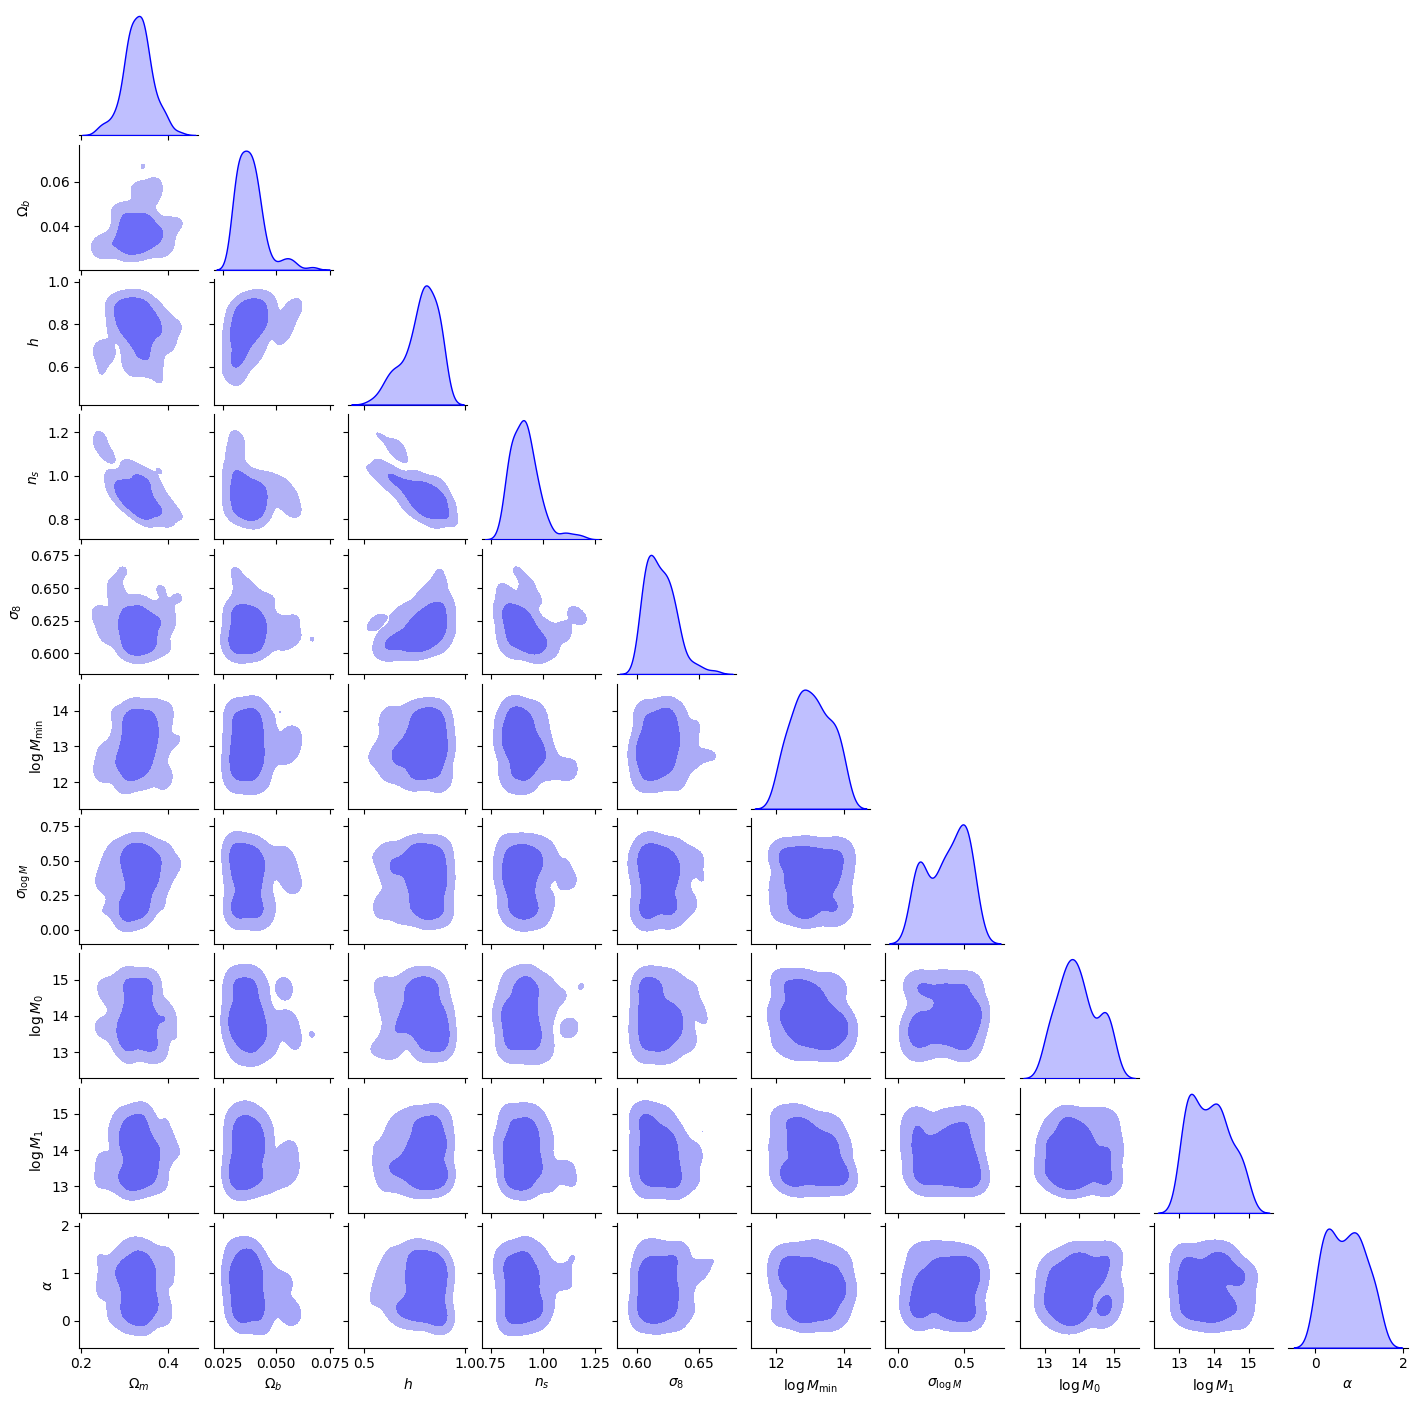

In [45]:
import seaborn as sns
fig = sns.pairplot(
    df1, 
    kind='kde', corner=True,
    plot_kws=dict(levels=[0.05, 0.32, 1], fill=True, color='blue'),
    diag_kws=dict(color='blue')
)

fig.fig.set_size_inches(14, 14)
fig.savefig('/home/x-mho1/git/ltu-gobig/experiments/mtnglike/big_corner.png', dpi=300)

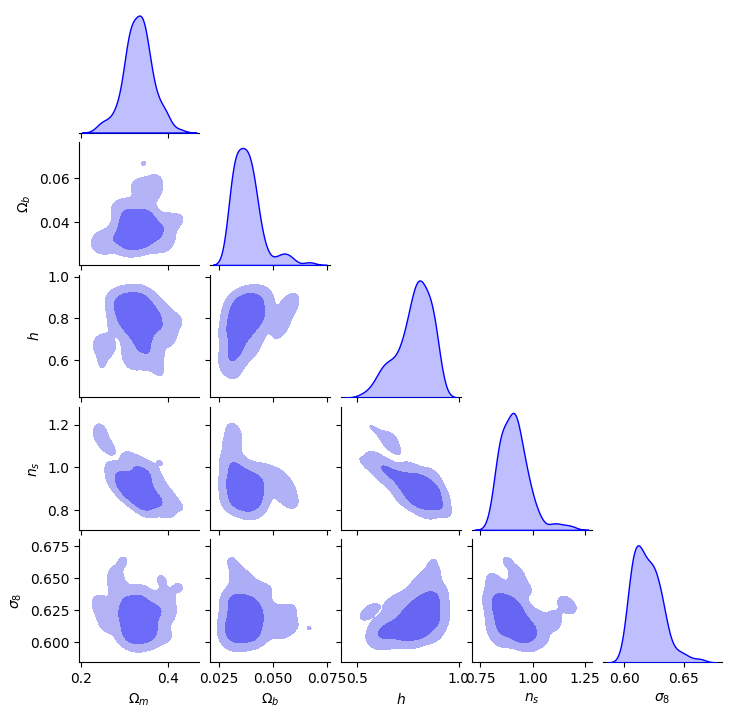

In [46]:
import seaborn as sns
fig = sns.pairplot(
    df1, 
    kind='kde', corner=True,
    vars=[r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$'],
    plot_kws=dict(levels=[0.05, 0.32, 1], fill=True, color='blue'),
    diag_kws=dict(color='blue')
)

fig.fig.set_size_inches(7, 7)
fig.savefig('/home/x-mho1/git/ltu-gobig/experiments/mtnglike/cosmo_corner.png', dpi=300)

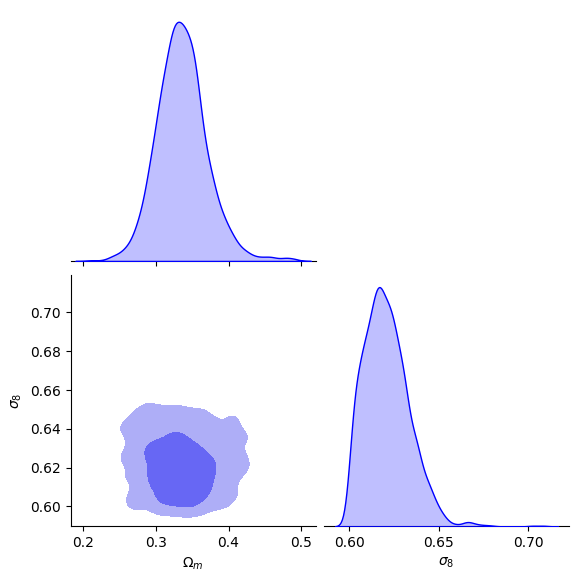

In [77]:
import seaborn as sns
fig = sns.pairplot(
    df1, 
    kind='kde', corner=True, # hue='Model',
    vars=[r'$\Omega_m$', r'$\sigma_8$'],
    # hue_order='
    plot_kws=dict(levels=[0.05, 0.32, 1], fill=True, common_norm=False, color='blue'),
    diag_kws=dict(common_norm=True, common_grid=True, color='blue')
)

fig.fig.set_size_inches(6, 6)
fig.savefig('/home/x-mho1/git/ltu-gobig/experiments/mtnglike/small_corner.png', dpi=300)

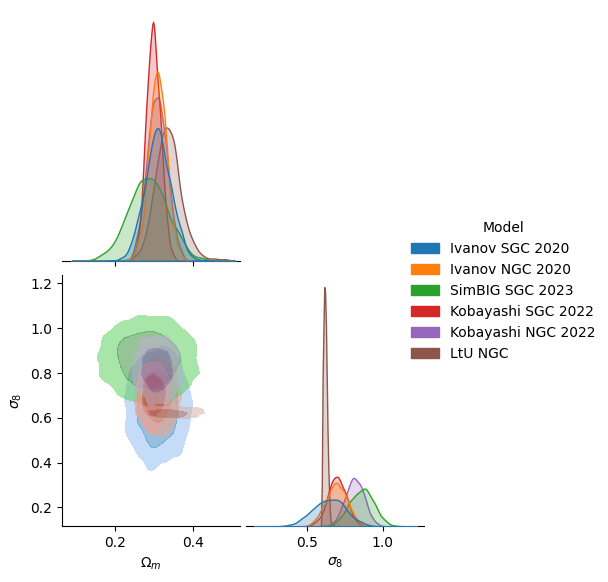

In [84]:
import seaborn as sns
fig = sns.pairplot(
    df, 
    kind='kde', corner=True, hue='Model',
    vars=[r'$\Omega_m$', r'$\sigma_8$'],
    # hue_order='
    plot_kws=dict(levels=[0.05, 0.32, 1], fill=True, common_norm=False, alpha=0.5),
    diag_kws=dict(common_norm=True, common_grid=True)
)

fig.fig.set_size_inches(6, 6)
fig.savefig('/home/x-mho1/git/ltu-gobig/experiments/mtnglike/every_corner.png', dpi=300)

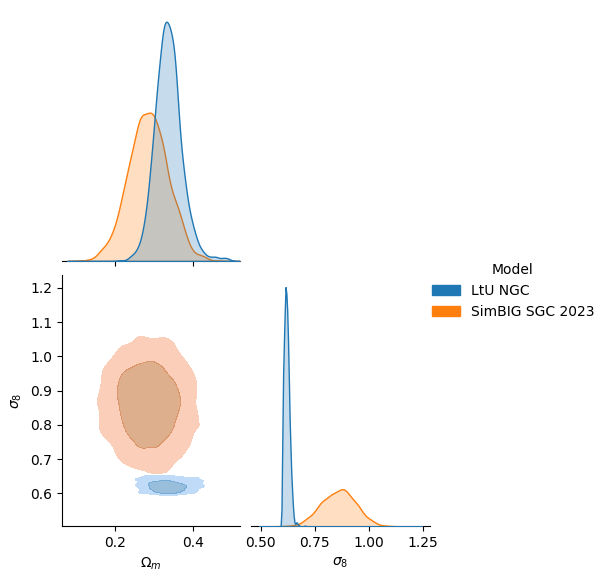

In [88]:
import seaborn as sns
dfi=pd.concat([df1, df3])
fig = sns.pairplot(
    dfi, 
    kind='kde', corner=True, hue='Model',
    vars=[r'$\Omega_m$', r'$\sigma_8$'],
    # hue_order='
    plot_kws=dict(levels=[0.05, 0.32, 1], fill=True, common_norm=False, alpha=0.5),
    diag_kws=dict(common_norm=True, common_grid=True)
)

fig.fig.set_size_inches(6, 6)
fig.savefig('/home/x-mho1/git/ltu-gobig/experiments/mtnglike/simbig_corner.png', dpi=300)

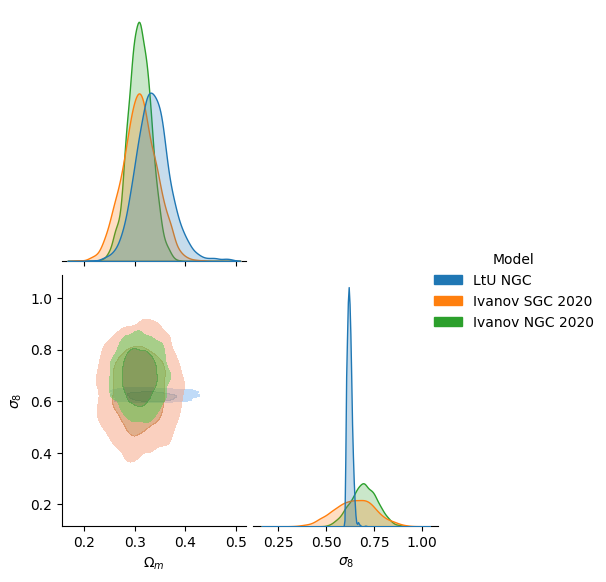

In [89]:
import seaborn as sns
dfi=pd.concat([df1, df4, df5])
fig = sns.pairplot(
    dfi, 
    kind='kde', corner=True, hue='Model',
    vars=[r'$\Omega_m$', r'$\sigma_8$'],
    # hue_order='
    plot_kws=dict(levels=[0.05, 0.32, 1], fill=True, common_norm=False, alpha=0.5),
    diag_kws=dict(common_norm=True, common_grid=True)
)

fig.fig.set_size_inches(6, 6)
fig.savefig('/home/x-mho1/git/ltu-gobig/experiments/mtnglike/ivanov_corner.png', dpi=300)

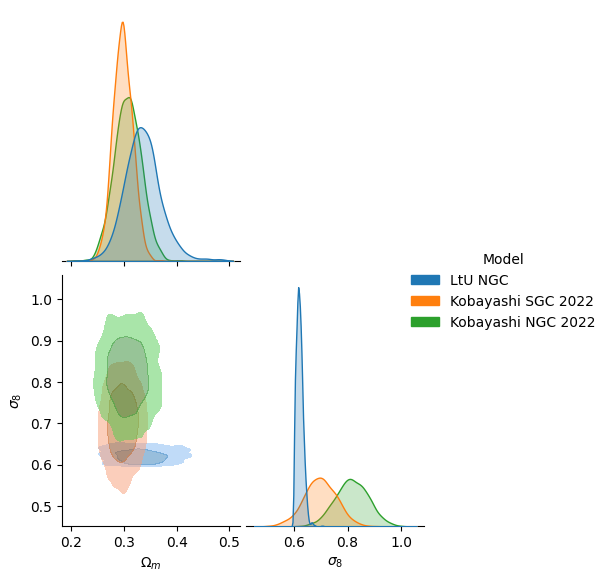

In [90]:
import seaborn as sns
dfi=pd.concat([df1, df6, df7])
fig = sns.pairplot(
    dfi, 
    kind='kde', corner=True, hue='Model',
    vars=[r'$\Omega_m$', r'$\sigma_8$'],
    # hue_order='
    plot_kws=dict(levels=[0.05, 0.32, 1], fill=True, common_norm=False, alpha=0.5),
    diag_kws=dict(common_norm=True, common_grid=True)
)

fig.fig.set_size_inches(6, 6)
fig.savefig('/home/x-mho1/git/ltu-gobig/experiments/mtnglike/kobayashi_corner.png', dpi=300)

In [ ]:
import seaborn as sns
fig = sns.pairplot(
    df, 
    kind='kde', corner=True, hue='Model',
    vars=[r'$\Omega_m$', r'$\sigma_8$'],
    # hue_order='
    plot_kws=dict(levels=[0.05, 0.32, 1], fill=True, common_norm=False, alpha=0.5),
    diag_kws=dict(common_norm=True, common_grid=True)
)

fig.fig.set_size_inches(6, 6)
fig.savefig('/home/x-mho1/git/ltu-gobig/experiments/mtnglike/every_corner.png', dpi=300)

[13:50:37-INFO] Sampling models with tensor([1000.]) samples each.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:  92%|█████████▏| 922/1000 [00:01<00:00, 590.99it/s]

Drawing 1000 posterior samples: 1831it [00:01, 1044.91it/s]                        
Drawing 1000 posterior samples:   0%|          | 0/1000 [10:50<?, ?it/s]


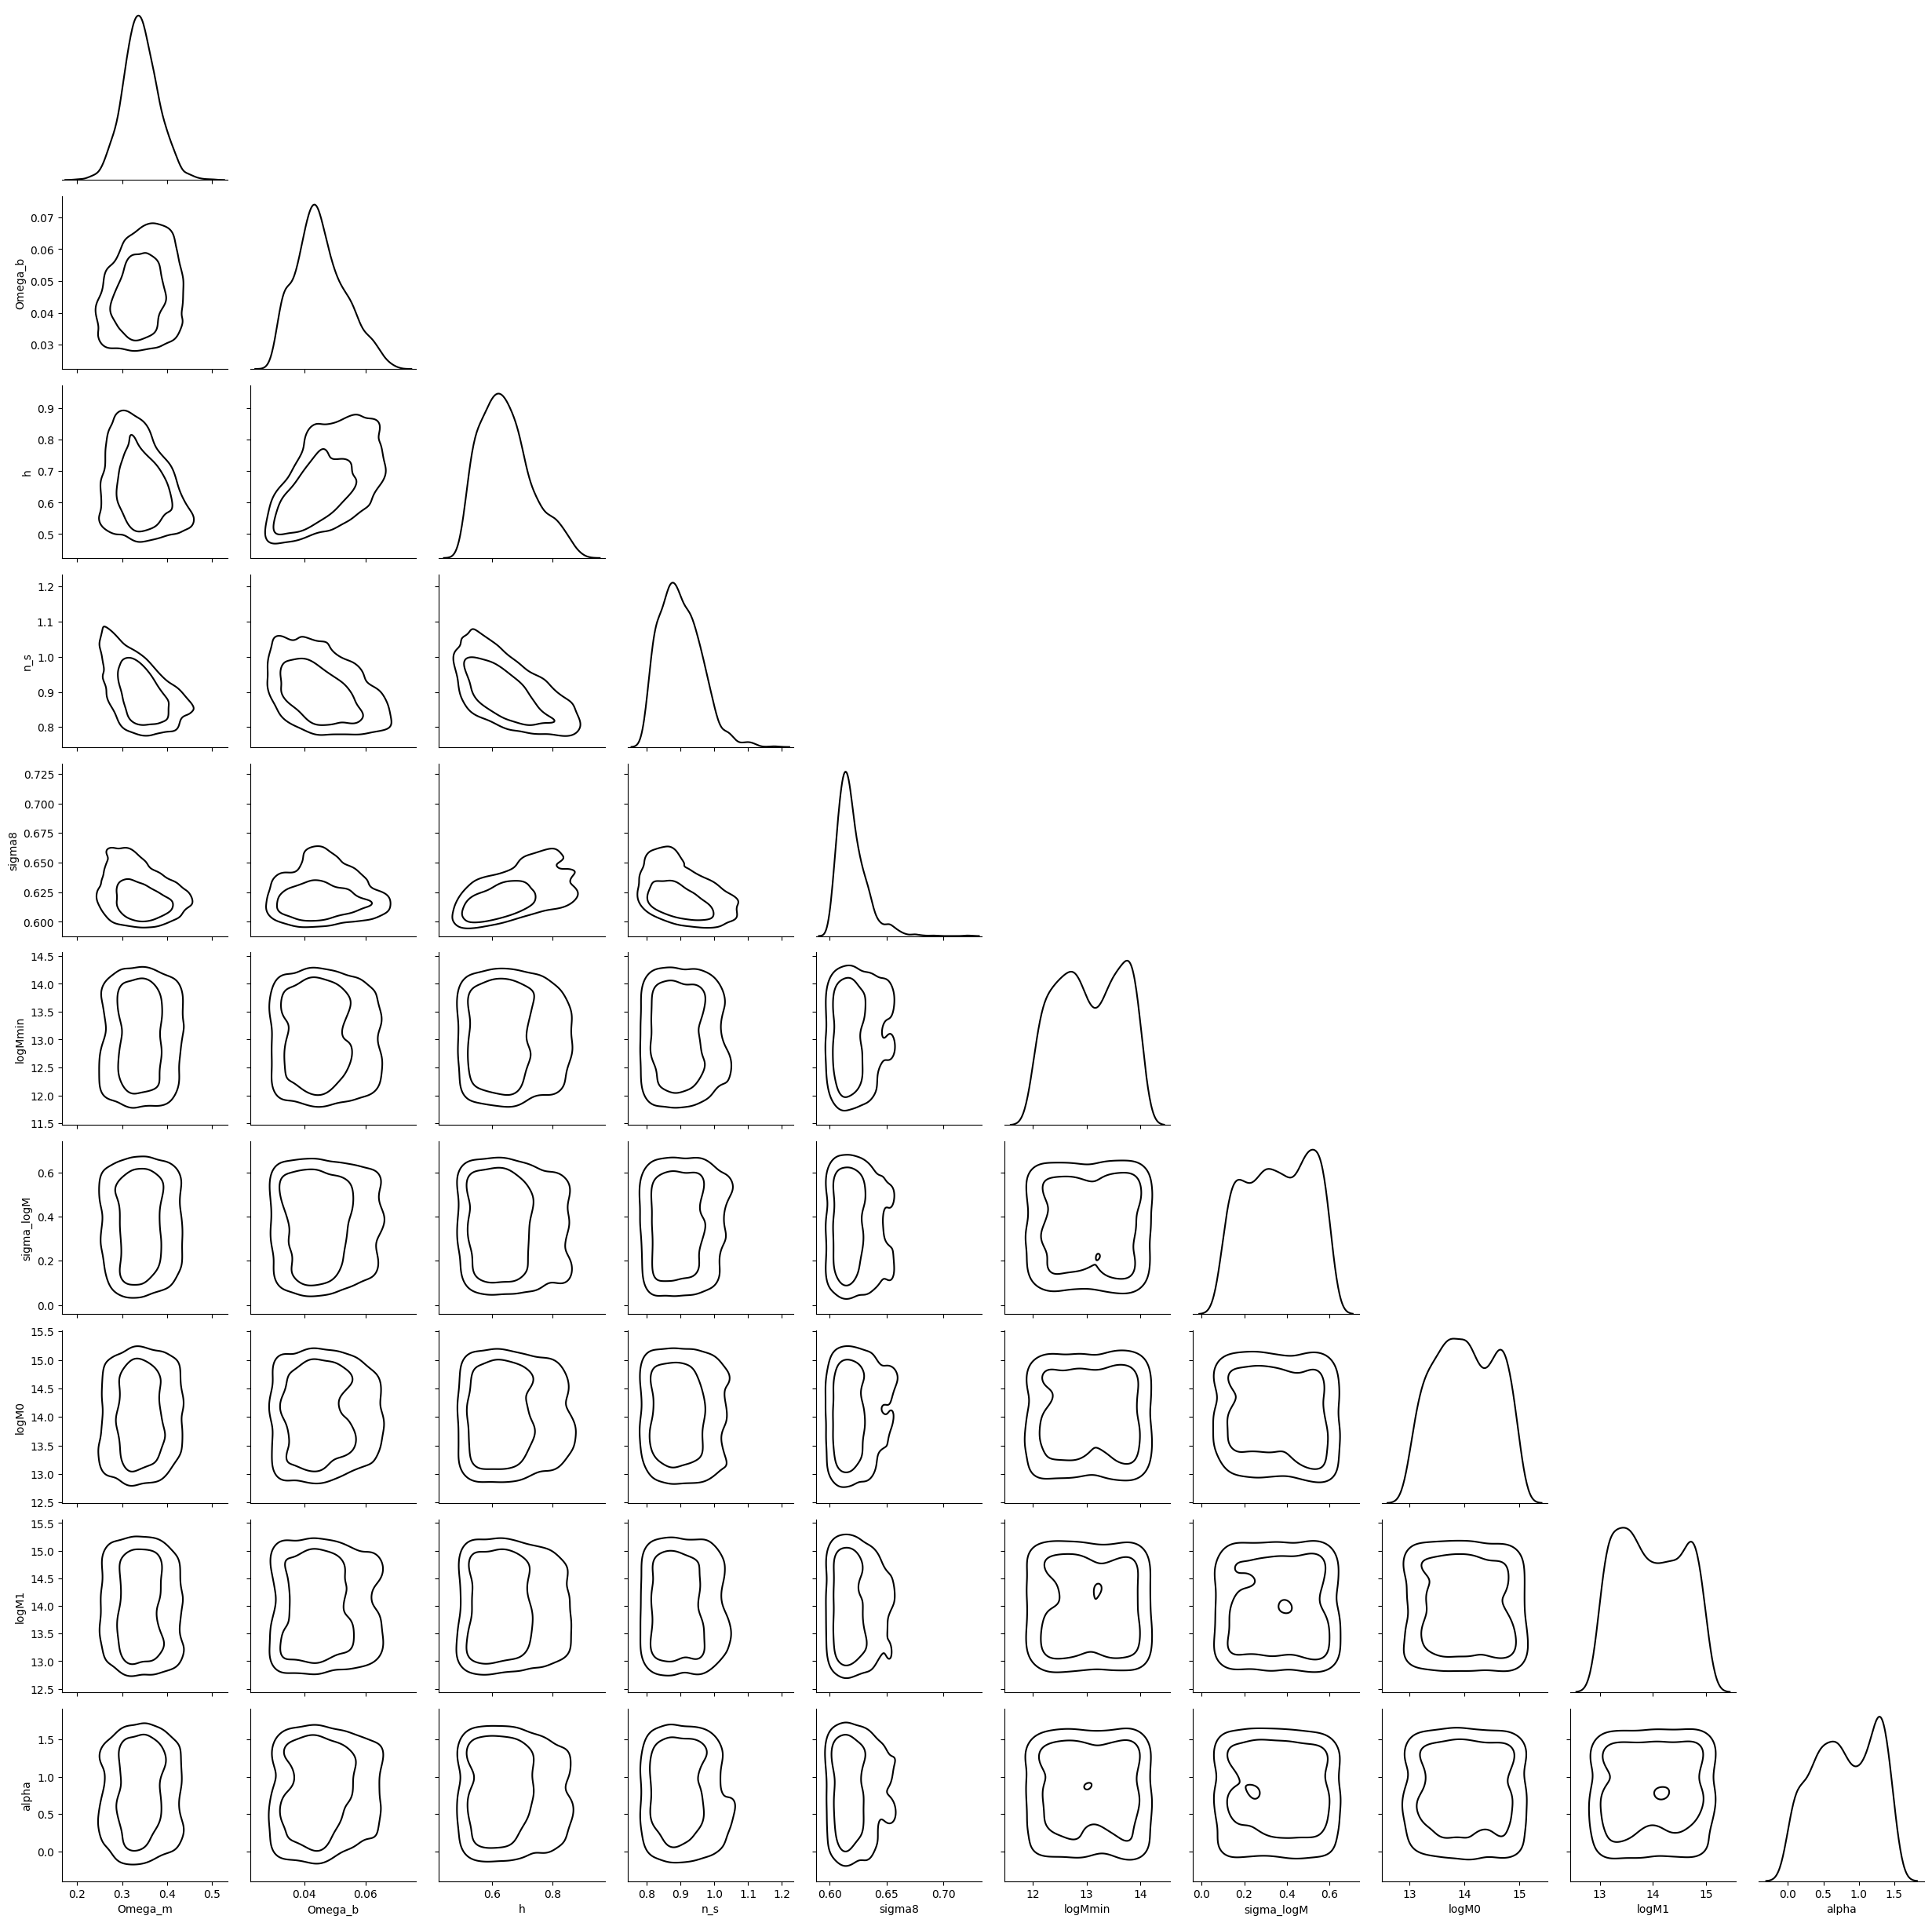

In [107]:
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'] + \
    ['logMmin', 'sigma_logM', 'logM0', 'logM1','alpha']
)
fig = None
for i, kmax in enumerate(kmaxs[:1]):
    # xobs = Pktrain[:, :, 0]
    # mask = ktest[0] < kmax
    # xobs = xobs[:, mask]
    # xobs = np.log10(xobs)
    # # xobs = impute(xobs)
    _p = posteriors[kmax]
    fig = metric(
        posterior=_p,
        x_obs = xobs, # theta_fid = thetaobs[0],
        grid=fig,
        name=f'kmax={kmax}'
    )

### Edit MTNG halos

In [11]:
# Test suite
suite = 'mtng'
sim = 'nbody'
L, N = 3000, 384

source_path = get_source_path(wdir, suite, sim, L, N, 0)
os.listdir(source_path)
with h5py.File(join(source_path, 'halos.h5'), 'r') as f:
    a = list(f.keys())[-1]
    hpos = f[a]['pos'][:]
    hvel = f[a]['vel'][:]
    hmass = f[a]['mass'][:]

In [13]:
mask = (hmass >= 13)
hpos = hpos[mask]
hvel = hvel[mask]
hmass = hmass[mask]

In [ ]:
from cmass.rho_to_halo

### Plot MTNG galaxies

In [ ]:
with h5py.File(join(source_path, 'galaxies', 'hod000.h5'), 'r') as f:
    a = list(f.keys())[-1]
    gpos = 